# Adaptation de modeles de vision pour la classification : k-NN classification

Dans ce TD, nous allons nous interesser au probleme de la classification d'images.
Nous allons utiliser des modeles de vision pre-entraines, et nous allons les adapter pour
classifier des images de jeux de donnees de notre choix. On commence par le mode d'adaptation le plus simple : k-nearest neighbors. Celui-ci ne demande pas de fine-tuning de head : on ne fait qu'utiliser les poids du backbone !

On met ici la liste complete des imports necessaires pour le TD.

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from PIL import Image
import requests
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import AutoImageProcessor, AutoModel

/opt/conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### 1. Prise en main de divers modeles de HuggingFace

L'approche classique est de recuperer un modele pre-entraine sur HuggingFace, et de l'adapter pour notre tache de classification. De nombreux modeles sont disponibles, et nous allons en tester plusieurs. Chaque modele a ses specificites, mais la librairie `transformers` est bien faite, et permet de les utiliser de maniere assez inetrchangeable (meme syntaxe, meme parametres, etc.)

Commencons donc par regarder un ResNet-50 pre-entraine sur ImageNet. La syntaxe reste la meme, on charge le modele et le processor associé, et on passe le modele sur GPU si disponible.

In [3]:
# from transformers import AutoImageProcessor, AutoModel

processor = AutoImageProcessor.from_pretrained('microsoft/resnet-50', use_fast=False)
model = AutoModel.from_pretrained('microsoft/resnet-50').to(DEVICE)
model.eval()

ResNetModel(
  (embedder): ResNetEmbeddings(
    (embedder): ResNetConvLayer(
      (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
    )
    (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (encoder): ResNetEncoder(
    (stages): ModuleList(
      (0): ResNetStage(
        (layers): Sequential(
          (0): ResNetBottleNeckLayer(
            (shortcut): ResNetShortCut(
              (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (normalization): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
            (layer): Sequential(
              (0): ResNetConvLayer(
                (convolution): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (normalizatio

On essaie maintenant de passer une image au modele, et de recuperer la prediction.

In [4]:
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)
inputs = processor(images=image, return_tensors="pt").to(DEVICE)
outputs = model(**inputs)
print(type(outputs))

<class 'transformers.modeling_outputs.BaseModelOutputWithPoolingAndNoAttention'>


In [5]:
print(outputs[1].shape)

torch.Size([1, 2048, 1, 1])


Pour verifier que tout se passe bien, on affiche l'image avant et apres passage dans le processor :

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


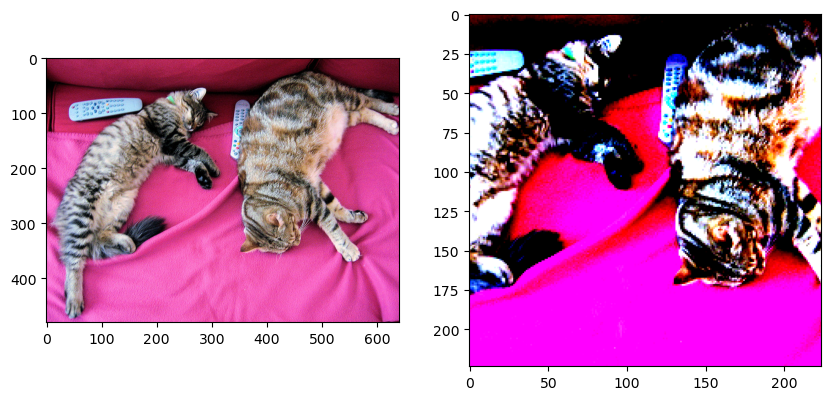

In [6]:
# import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(image)
axs[1].imshow(inputs['pixel_values'][0].cpu().numpy().transpose(1, 2, 0))
plt.show()

ATTENTION : il faut toujours bien verifier le range des donnees en entree necessaire au processor !! La plupart des modeles pre-entraines s'attendent a des images entre 0 et 1, et les processors associes attendent des images entre 0 et 255, qu'ils normalisent ensuite a [0, 1].

Tant qu'on reste dans le domaine des images RGB, il n'y a en general pas de probleme. Mais si on veut traiter des images en niveaux de gris, ou des images en couleurs avec 3 canaux, il faut bien faire attention a bien normaliser les donnees en entree au processor.

### 2. Preparation du dataset

Nous allons utiliser le jeu de donnees classique [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) comme exemple dans ce TD. On commence par definir les datasets d'entrainement et de validation et les dataloaders associés.

In [7]:
from torchvision.datasets import CIFAR10

def get_dataloaders(
    url_data_dir: str = './data',
    batch_size: int = 16,
    num_workers: int = 0,
) -> tuple[DataLoader, DataLoader]:

    transform = transforms.Compose(
        [
            transforms.Resize((224, 224)),  # les modeles attendent des images de taille 224x224
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x * 255),  # le processor attend des images entre 0 et 255
            transforms.Lambda(lambda x: x.to(torch.uint8))  # pour minimiser la memoire utilisee
        ]
    )
    # ATTENTION : il ne faut pas normaliser les données entre 0 et 1, c'est géré par le processor.

    # On utilise la fonction `CIFAR10` de torchvision pour charger les données.
    train_dataset = CIFAR10(root=url_data_dir, train=True, download=True, transform=transform)
    test_dataset = CIFAR10(root=url_data_dir, train=False, download=True, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, test_loader

### 3. k-NN classification

(1) Ecrire une fonction `load_model_and_processor` qui, a partir d'un nom de modele sur HuggingFace, charge et renvoie le modele et le processor associé sur un device donné.

In [8]:
def load_model_and_processor(model_name: str, device: str = 'cuda') -> tuple:
    processor = AutoImageProcessor.from_pretrained(model_name, use_fast=False)
    model = AutoModel.from_pretrained(model_name).to(device)
    model.eval()
    return model, processor

(2) Ecrire une fonction `extract_features` qui prend en argument un modele, un processor, un dataloader et un device, et calcule les features des images du dataloader, et les renvoie avec les labels associés. Attention au format des outputs du modele ! Dans le cas du ResNet-50, par exemple, les features sont de dimension (2048, 1, 1) et il faut donc retirer les deux dernieres dimensions apres concatenation, avant de les envoyer au kNN.

In [9]:
def extract_features(
    model,
    processor,
    loader,
    device: str = 'cuda',
) -> tuple[np.ndarray, np.ndarray]:

    features, labels = [], []
    with torch.no_grad():
        for images, targets in tqdm(loader):
            inputs = processor(images=images, return_tensors="pt").to(device)
            outputs = model(**inputs)
            cls_tokens = outputs[1]
            features.append(cls_tokens.cpu().numpy())
            labels.append(targets.numpy())

    features = np.concatenate(features)
    labels = np.concatenate(labels)

    return features, labels

(3) En utilisant les fonctions `KNeighborsClassifier` et `accuracy_score` de scikit-learn, ecrire une fonction `knn_classification` qui prend en argument les features et les labels d'entrainement et de test, et un nombre de plus proches voisins, et qui renvoie la precision de classification du kNN.

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [11]:
def knn_classification(
    train_features,
    train_labels,
    test_features,
    test_labels,
    n_neighbors: int = 5,
    metric: str = 'cosine',
) -> float:
    knn = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric)
    knn.fit(torch.tensor(train_features).squeeze(), torch.tensor(train_labels))
    test_predictions = knn.predict(torch.tensor(test_features).squeeze())
    return accuracy_score(test_labels, test_predictions)

(4) Enfin, calculez la precision de classification du kNN sur le jeu de donnees CIFAR10 !

In [12]:
train_loader, test_loader = get_dataloaders(
    url_data_dir='./data/cifar10/',
    batch_size=128,
    num_workers=4,
)

train_features, train_labels = extract_features(model, processor, train_loader, device=DEVICE)
test_features, test_labels = extract_features(model, processor, test_loader, device=DEVICE)

accuracy = knn_classification(
    train_features,
    train_labels,
    test_features,
    test_labels,
    n_neighbors=5,
)
print(f'kNN classification accuracy: {accuracy * 100:.2f}%')

100%|██████████| 79/79 [01:14<00:00,  1.06it/s]


kNN classification accuracy: 85.64%
